<a href="https://colab.research.google.com/github/yeb2Binfang/DS_GY_3001_CV/blob/main/HW/HW2/homework2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Homework 2: Canny edge detector

**Due date:** October 15th 2019

The goal of the assignment is to implement a Canny edge detector. You should return the completed notebook, including answers and illustrations. 

If you are using [anaconda](https://www.anaconda.com/distribution/) you will have necessary libraries, if not, you may need to install them.

**Load and visualize image**

--2021-03-11 17:48:24--  https://raw.githubusercontent.com/yeb2Binfang/DS_GY_3001_CV/main/HW/HW2/lena.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105764 (103K) [image/jpeg]
Saving to: ‘lena.jpg’

lena.jpg            100%[===================>] 103.29K  --.-KB/s    in 0.02s   

2021-03-11 17:48:24 (4.16 MB/s) - ‘lena.jpg’ saved [105764/105764]



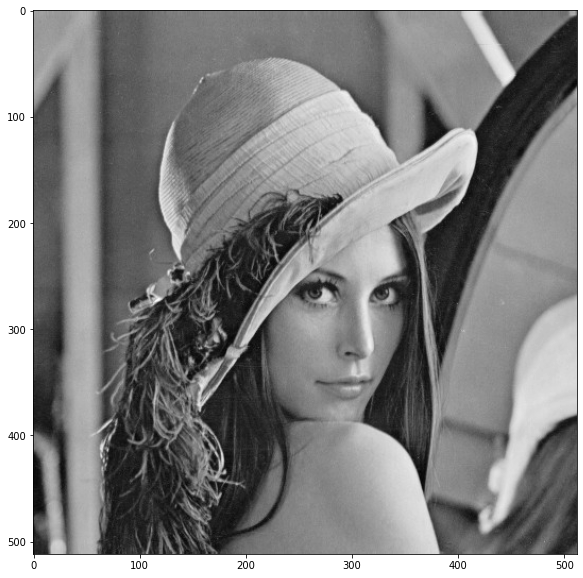

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 
import scipy.ndimage as ndimage #image processing library

# by default, the grayscale images are displayed with the jet colormap: use grayscale instead
plt.rcParams['image.cmap'] = 'gray'  

def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray
# get image
!wget https://raw.githubusercontent.com/yeb2Binfang/DS_GY_3001_CV/main/HW/HW2/lena.jpg -O lena.jpg
name = './lena.jpg'
img = plt.imread(name)
img = rgb2gray(img)
plt.figure(figsize=(10,10)) # this allows you to control the size of the displayed image
plt.imshow(img)

**Detailed instructions:**

https://www.cnblogs.com/king-lps/p/8007134.html

a- Compute a binary image corresponding to thresholding the norm of the gradient. You may use the function `ndimage.gaussian_filter` to compute the derivative of gaussian filter (see [docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.gaussian_filter.html)). Discuss the parameters (there are two) and their influence on the results.

steps:
Explain the reason why we need to remove the noise

In [2]:
import cv2
img_remove = cv2.GaussianBlur(img,(5,5),0) # Apply Gaussian filter to remove noise

compare the spectrogram

In [3]:
def get_spectrogram(img):
  ## must be grey image
  f = np.fft.fft2(img)
  fshift = np.fft.fftshift(f)
  fimg = np.log(np.abs(fshift))
  plt.imshow(fimg, 'gray')

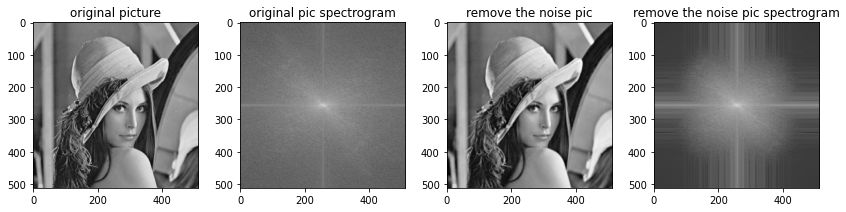

In [4]:
plt.figure(figsize=(12,8))

plt.subplot(141)
plt.imshow(img)
plt.title('original picture')

plt.subplot(142)
get_spectrogram(img)
plt.title('original pic spectrogram')

plt.subplot(143)
plt.imshow(img_remove)
plt.title('remove the noise pic')

plt.subplot(144)
get_spectrogram(img_remove)
plt.title('remove the noise pic spectrogram')

plt.tight_layout()

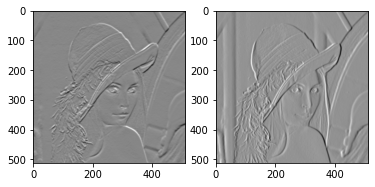

In [5]:
from scipy.ndimage import gaussian_filter
plt.subplot(121)
Gy=ndimage.gaussian_filter(img_remove, 1, (1,0))
plt.imshow(Gy)

plt.subplot(122)
Gx=ndimage.gaussian_filter(img_remove, 1, (0,1))
plt.imshow(Gx)



In [7]:
G = np.sqrt(Gx**2+Gy**2)
G *= 255.0 / G.max()

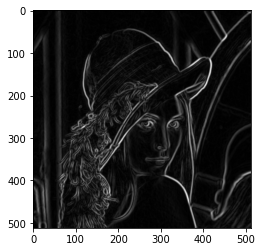

In [8]:
plt.imshow(G)

In [9]:
print(G)

[[ 0.14104889  0.69033029  2.13604142 ... 35.77971604 37.73145338
  15.4667642 ]
 [ 0.41658676  1.10920571  2.50985108 ... 35.63511334 37.34698863
  15.42847224]
 [ 0.61191295  1.88677354  3.10855443 ... 39.42267379 40.6770713
  22.60899746]
 ...
 [ 6.17139899  7.79588786  7.36638926 ... 14.05313181 14.36984051
  15.49054302]
 [ 4.29144825  9.38095451  9.61326065 ...  9.62856841  9.57442514
  10.55522281]
 [ 4.27996196 10.72423338 10.62888925 ...  7.17669651  5.03776071
   3.79796279]]


In [10]:
## calculate the theta
import math
g_theta = np.arctan2(Gy,Gx)
gx,gy = g_theta.shape
theta = np.zeros((gx,gy))
for i in range(gx):
  for j in range(gy):
    theta[i][j] = np.rad2deg(g_theta[i][j])
print(np.min(theta))

-179.99989265698957


In [11]:
print(np.max(G))

255.0


In [ ]:
m,n = G.shape
nms_img = np.zeros((m,n))
print(nms_img[0][0])

0.0


In [12]:
def threshold_norm(G,threshold):
  m,n = G.shape
  threshold_norm_G = np.zeros((m,n))
  for i in range(1,m-1):
    for j in range(1,n-1):
      if G[i][j]>threshold:
        threshold_norm_G[i][j] = G[i][j]
  return threshold_norm_G

In [13]:
threshold_norm_G = threshold_norm(G,5)

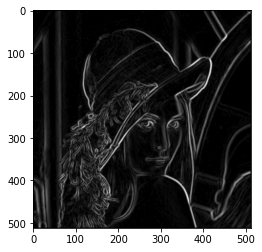

In [14]:
plt.imshow(threshold_norm_G)

In [15]:
print(threshold_norm_G)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ... 35.63511334 37.34698863
   0.        ]
 [ 0.          0.          0.         ... 39.42267379 40.6770713
   0.        ]
 ...
 [ 0.          7.79588786  7.36638926 ... 14.05313181 14.36984051
   0.        ]
 [ 0.          9.38095451  9.61326065 ...  9.62856841  9.57442514
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]


In [16]:
print(theta)

[[ 120.64642118 -176.79062234 -173.67176719 ... -179.34301653
  -179.82846093  179.57670268]
 [ 126.99452753 -173.12603038 -164.01424753 ... -174.93074795
  -175.76032241 -171.34856053]
 [ 160.29816328 -166.6699024  -158.12916711 ... -156.57175639
  -155.69871292 -131.8061183 ]
 ...
 [ -64.05716306  -27.60811255   -6.40508199 ...   69.30822604
    86.11648351   90.13574917]
 [ -30.72547739   -4.1261862     7.97151991 ...   52.00691625
    73.44647589   85.9956744 ]
 [  -5.04943709    0.75892204    4.26395472 ...   19.25215266
    36.89981511   70.00247137]]


b- Write a function `nms(g_norm,g_theta)` which takes as input the gradient norm and direction and outputs a binary image with value 1 only for pixels that correspond to a maximum in the direction of the gradient.

In [17]:
def nms(g_norm, g_thetea):
    img_row, img_col = g_norm.shape

    nms_img = np.zeros(g_norm.shape)

    q = r= 255
    for row in range(1, img_row - 1):
        for col in range(1, img_col - 1):
            degree = g_theta[row, col]

            # (0 - PI/8 and 15PI/8 - 2PI)
            if (-22.5 <= degree < 22.5) or (degree<-157.5):
                q = g_norm[row, col - 1]
                r = g_norm[row, col + 1]

            elif (22.5 <= degree < 67.5) or (-157.5 <= degree < -112.5):
                q = g_norm[row + 1, col - 1]
                r = g_norm[row - 1, col + 1]

            elif (67.5 <= degree < 112.5) or (-112.5 <= degree < -67.5):
                q = g_norm[row - 1, col]
                r = g_norm[row + 1, col]

            else:
                q = g_norm[row - 1, col - 1]
                r = g_norm[row + 1, col + 1]

            if g_norm[row, col] >= q and g_norm[row, col] >= r:
                nms_img[row, col] = g_norm[row, col]

    return nms_img

In [18]:
nms_img = nms(threshold_norm_G,g_theta)

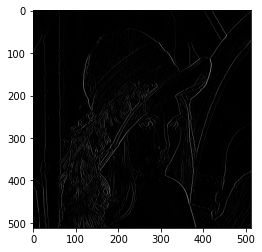

In [19]:
plt.imshow(nms_img)

Text(0.5, 1.0, 'nms_img')

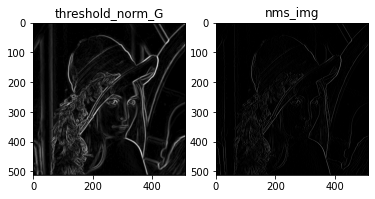

In [20]:
plt.subplot(121)
plt.imshow(threshold_norm_G)
plt.title("threshold_norm_G")
plt.subplot(122)
plt.imshow(nms_img, cmap = plt.get_cmap('gray'))
plt.title("nms_img")

c- Combine step 'a' and 'b' to extract edges with a gradient norm larger than a given threshold.

d- Add the hysteresis thresholding to step 'c' to implement a function computing the Canny edges.

Here is one way to do the hysteresis thresholding. Apply step 'c' with two thresholds $t_1 < t_2$. This yields a set of "strong pixels" (large threshold) and "weak pixels" (small threshold). Initialize a list of edge pixels by including only the set of strong pixels. For each pixel in this list, check if its neighboors are weak pixels. If they are, add them to the list of pixels to visit.

In [39]:
def threshold(img, lowThresholdRatio, highThresholdRatio):
    
  highThreshold = img.max() * highThresholdRatio;
  lowThreshold = highThreshold * lowThresholdRatio;
  
  M, N = img.shape
  res = np.zeros((M,N))
  
  weak = 100
  strong = 255
  
  strong_i, strong_j = np.where(img >= highThreshold)
  zeros_i, zeros_j = np.where(img < lowThreshold)
  
  weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
  
  res[strong_i, strong_j] = strong
  res[weak_i, weak_j] = weak
  
  return res, weak, strong

In [40]:
def hysteresis(img, weak, strong):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

In [41]:
fin, weak, strong = threshold(nms_img, 0.09, 0.2)

In [42]:
fin1 = hysteresis(fin,weak, strong)

e- Run your code on at least four images of your own choosing. Use different parameters and comment on their effects.

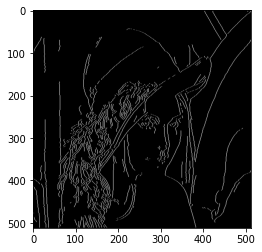

In [43]:
plt.imshow(fin1)

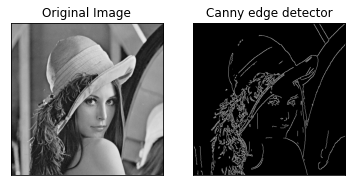

In [37]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img1 = cv2.imread('lena.jpg',0)
edges = cv2.Canny(img1,150,230)

plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Canny edge detector'), plt.xticks([]), plt.yticks([])

plt.show()

In [35]:
nnnn = np.zeros((512,512))
for i in range(512):
  for j in range(512):
    if i%20==0:
      nnnn[i,j]=255

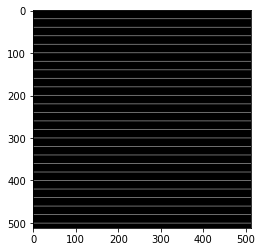

In [36]:
plt.imshow(nnnn)